In [136]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')


In [70]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [72]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0, fixed_boundaries=True):

    h5store = 'Documents/Code/tyssue/doc/examples/before_apoptosis.hf5'
    #h5store = '../data/hf5/small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('fold', datasets, specs)
    sheet.sanitize()
    geom.update_all(sheet)

    sheet.edge_df['opposite'] = sheet.get_opposite()

    sheet.vert_df.is_active = 1
    if anchor_tension > 0:
        create_anchors(sheet)
        nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
        nondim_specs['edge']['anchor_tension'] = anchor_tension
    else:
        nondim_specs = config.dynamics.quasistatic_sheet_spec()
        if fixed_boundaries:
            free_edges = sheet.edge_df[sheet.edge_df.opposite==-1].index
            free_srces = set(sheet.edge_df.loc[free_edges, 'srce'])
            sheet.vert_df.loc[free_srces, 'is_active'] = 0
            sheet.edge_df.loc[free_edges, 'is_active'] = 0
            free_faces = set(sheet.edge_df.loc[free_edges, 'face'])
            sheet.face_df.loc[free_faces, 'is_alive'] = 0

    dim_model_specs = model.dimensionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)
    # isotropic_relax(sheet, nondim_specs)
    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet, nondim_specs

sheet, nondim_specs = load_before_apopto(0, fixed_boundaries=True)

geom.update_all(sheet)



Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_height of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs
Reseting column radial_tension of the vert dataset with new specs
Reseting column is_active of the vert dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs


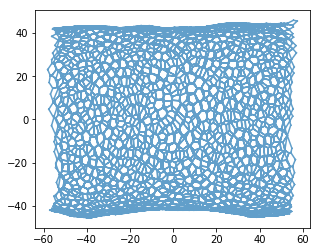

In [85]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)




In [94]:
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.267004, 0.004874, 0.329415],
       [0.282327, 0.094955, 0.417331],
       [0.276194, 0.190074, 0.493001],
       ...,
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415]]), lines=array([[   0,    1],
       [   3,    0],
       [   1,    6],
       ...,
       [3389, 1084],
       [3390, 3389],
       [1031, 3390]], dtype=uint32), texture=None, x=array([-55.4192407 , -54.47865147, -55.82444874, ..., -41.24222194,
        -4.215532  ,  -3.06444594]), y=array([ 42.1421576 ,  42.28524539,  41.76489078, ...,  19.3827108 ,
       -37.70299544, -39.38137112]), z=array([ -0.24862425,   2.93541823,   6.37122128, ..., -41.13670401,
       -18.48112659, -14.14550463]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-63.872795755640794, 63.17719275850132], ylim=[-63.872795755640794, 63.17719275850132], zlim=[-63.872795755640794, 63.17719275850132])

In [66]:
sheet.face_df.columns

Index(['z', 'area', 'is_alive', 'perimeter', 'x', 'y', 'old_idx', 'num_sides',
       'vol', 'prefered_area', 'contractility', 'vol_elasticity',
       'prefered_height', 'prefered_vol', 'basal_shift'],
      dtype='object')

In [67]:
sheet.edge_df.columns

Index(['srce', 'trgt', 'face', 'length', 'dy', 'dz', 'ny', 'nx', 'dx', 'nz',
       'sub_area', 'sub_vol', 'line_tension', 'sx', 'sy', 'sz', 'tx', 'ty',
       'tz', 'fx', 'fy', 'fz', 'is_active'],
      dtype='object')

In [68]:
sheet.vert_df.columns

Index(['is_active', 'z', 'x', 'y', 'old_idx', 'basal_shift', 'rho', 'height',
       'radial_tension'],
      dtype='object')

In [83]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


In [133]:
def run_sim(sim_save_dir, sheet, nbApoptoCell, iteration=0):
    
    dirname = '{}_apoptoticCell_{}'.format(
        nbApoptoCell, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass

    
    apoptosis_settings = {
        "shrink_rate": 0.1,
        "critical_area": 1e-2,
        "radial_tension": 0.1,
        "contractile_increase": 0.1,
        "contract_span": 2,
        "geom": geom,
    }
    
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    solver_kw = {'minimize': {'method': 'L-BFGS-B',
                              'options': {'ftol': 1e-8,
                                          'gtol': 1e-8}}}
    #res = solver.find_energy_min(sheet2, geom, model, **solver_kw)

    sheet2 = apoptosis_process(dirname, solver, solver_kw, sheet2, geom, model,
                     nbApoptoCell)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [150]:
def apoptosis_process(dirname, solver, solver_kw, sheet, geom, model, nbApoptoCell):
    
    # Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0
    
    t = 0
    stop = 200
    sheet.face_df['contract_rate'] = 0
    
    apopto_cell=(np.linspace(0,1660,100)).astype(int, copy=False)
    
    # Add cell in apoptosis process
    for f in apopto_cell: 
        x = sheet.face_df.loc[f, 'x']
        apopto_kwargs = sheet.settings['apoptosis'].copy()
        apopto_kwargs.update(
            {
                'face_id': f,
            }
        )
        manager.append(apoptosis, **apopto_kwargs)
        
        
    # Run simulation
    while manager.current and t < stop:
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        hdf5.save_datasets(hdfname, sheet)

        manager.update()
        t += 1

    return sheet


In [151]:
# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))


nbApoptoCell = [1, 5, 10]

for nbCell in nbApoptoCell:
    for iteration in range (0, 1):
        run_sim(sim_save_dir, sheet, nbCell, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-05-15 15:40:27.258059
starting /home/admin-suz/Documents/Simulations/2019-05-15/1_apoptoticCell_0


/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['opposite']]



/home/admin-suz/Documents/Simulations/2019-05-15/1_apoptoticCell_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-15/5_apoptoticCell_0
/home/admin-suz/Documents/Simulations/2019-05-15/5_apoptoticCell_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-15/10_apoptoticCell_0
/home/admin-suz/Documents/Simulations/2019-05-15/10_apoptoticCell_0 done
~~~~~~~~~~~~~~~~~~~~~

end : 2019-05-15 19:29:06.267789
Duree totale d execution : 
		
3:48:39.009730


In [148]:
%pdb

Automatic pdb calling has been turned ON


In [154]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/2019-05-15')
dirname = SIM_DIR/'1_apoptoticCell_0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0025.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.133743, 0.548535, 0.553541],
       [0.123463, 0.581687, 0.547445],
       [0.119699, 0.61849 , 0.536347],
       ...,
       [0.208623, 0.367752, 0.552675],
       [0.185556, 0.41857 , 0.556753],
       [0.120638, 0.625828, 0.533488]]), lines=array([[   0,    1],
       [   3,    0],
       [   1,    6],
       ...,
       [3386, 1082],
       [3387, 3386],
       [1029, 3387]], dtype=uint32), texture=None, x=array([-27.25283958, -27.63285683, -29.24699785, ...,  -2.44753544,
        -1.33423838, -15.94023273]), y=array([ 48.17613908,  48.08033402,  46.85794227, ..., -43.03796822,
       -44.99612211, -48.6966548 ]), z=array([ -1.39501632,   2.01508968,   6.37275137, ..., -21.5069814 ,
       -16.23573135,   7.26958834])), Mesh(color=array([[0.90403691, 0.94297578, 0.97933103],
       [0.14666667, 0.46039216, 0.71869281],
       [0.09634756, 0.40081507, 0.67673972],
       ...,
       [0.0532872 , 0.34569781, 0.63367935],
       [0.0532872 , 0.34569781, 0.63367935],
       [0.0532872 , 0.34569781, 0.63367935]]), texture=None, triangles=array([[    0,  1661, 11627],
       [    0,  1662, 11628],
       [    0,  1663, 11629],
       ...,
       [ 1660, 11624, 21590],
       [ 1660, 11625, 21591],
       [ 1660, 11626, 21592]], dtype=uint32), x=array([-27.2563065 , -24.73662076, -23.737932  , ...,  -0.32460129,
        -2.44753544,  -1.33423838]), y=array([ 48.17741915,  49.97120597,  50.43155854, ..., -42.06933299,
       -43.03796822, -44.99612211]), z=array([ -1.33131508,   0.3557433 ,  -4.54974798, ..., -23.59351578,
       -21.5069814 , -16.23573135]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-58.75837540308266, 58.77779328922469], ylim=[-58.75837540308266, 58.77779328922469], zlim=[-58.75837540308266, 58.77779328922469])